# INTRODUCTION TO ARTIFICIAL INTELLIGENCE AND DEEP LEARNING FOR ENGINEERS AND SCIENTISTS

youtube video link:
https://youtu.be/a_sN_dUakMY

# import all necessary modules

1.   tensorflow <- core 
2.   tensorflow_datasets <- emnist dataset
3.   numpy <- mathematical operation with tensors
4.   matplotlib <- plotting

 



In [1]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_datasets as tfds
print(tfds.__version__)

import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt

2.2.0
2.1.0
1.18.5


# loading of emnist dataset

https://www.nist.gov/itl/products-and-services/emnist-dataset

It might take up to several minutes to download and prepare the dataset. After it is done I receive three variables:


1.   ds_train - training dataset
2.   ds_test - testing dataset
3.   ds_info - information about dataset: number of classes, number of samples in training and testing datasets etc. (ds_info will be printed below)

### NOTE:

I have tried following datasets:

**ByClass** - final subdataset: contains all the lowercase and uppercase letters of english alphabet and digits 0 -> 9

**Balanced** - after a little bit of research I discovered that this subdataset is not suitable for my uscase since it does not contain all the lowercase letters of english aplhabets !

**Letters** - this dataset does not contain lowercase letters of english alphabet -> might be suitable for my usecase but I tought that both uppercase and lowercase combined would be more challenging


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/byclass',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)
print(ds_info)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteVOAXF0/emnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteVOAXF0/emnist-test.tfrecord


Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='emnist',
    version=3.0.0,
    description='The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.

Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.',
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=62),
    }),
    total_num_examples=814255,
    splits={
        'test': 116323,
        'train': 697932,
    },
    supervised_keys=('image

For better debug and reader experience I translate labels of letter samples from numbers to corresponding letter character.

In [3]:
def label_translate(n):
  if n < 10:
    return str(n)
  elif n <= 35:
    return chr(n - 10 + 65)
  else:
    return chr(n + 61)

To verify the dataset I print representative samples of each class from 0 to 61 below. One can see that the dataset appears to be complete and the imagination of the quality of the letters is provided.

**for instance**: we can see that than instead of the letter 'r' it appears to be rather letter 'e' -> now we know that we are not working with the perfect dataset and accuracy of our classifier can be affected by this fact 

NOTE: before printing it is suitable to transpose the image since it is not stored in a human readable format in the original dataset. 

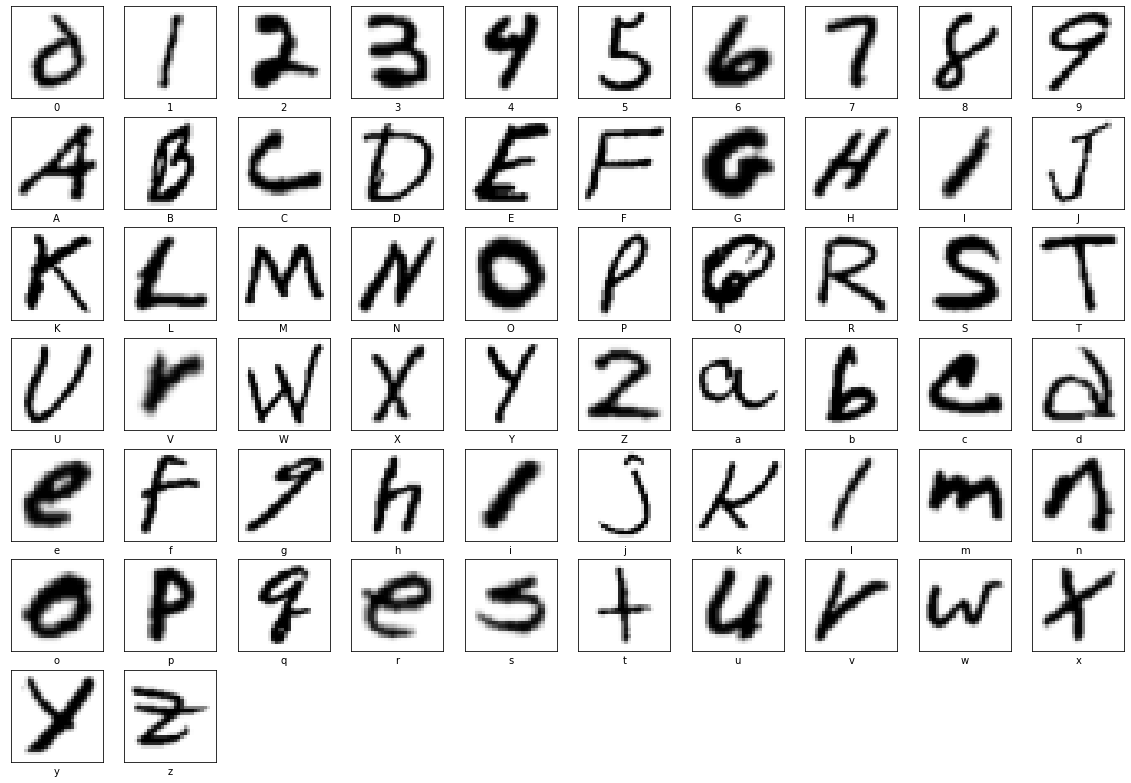

In [4]:
i = 0
j = 0 

plt.figure(figsize=(20,20))

d = dict()
for ii in range(0,62):
  d[str(ii)] = False

for sample in ds_test:
  l = sample[1].numpy()

  d[str(l)] = True 

  if l == i:
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(tf.transpose(tf.reshape(sample[0],[28,28])), cmap=plt.cm.binary)
    plt.xlabel(label_translate(l))

    i = i + 1
    if i == 62:
      break

  j = j + 1

plt.show()

Double check that all the classes are present.

In [5]:
for i in range(0,62):
  print(i,d[str(i)])

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
13 True
14 True
15 True
16 True
17 True
18 True
19 True
20 True
21 True
22 True
23 True
24 True
25 True
26 True
27 True
28 True
29 True
30 True
31 True
32 True
33 True
34 True
35 True
36 True
37 True
38 True
39 True
40 True
41 True
42 True
43 True
44 True
45 True
46 True
47 True
48 True
49 True
50 True
51 True
52 True
53 True
54 True
55 True
56 True
57 True
58 True
59 True
60 True
61 True


Function to normalize the samples -> /255 and typecasting is being done

In [6]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32) / 255., label

## preparation of the training dataset:


1.   normalize samples
2.   shuffle samples
3.   create batches (boost performace: https://www.tensorflow.org/guide/data_performance)
4.   prefetch (boost performance: https://www.tensorflow.org/guide/data_performance)




In [7]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

similar to training dataset

In [8]:
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.shuffle(ds_info.splits['train'].num_examples)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

# MODEL

create the sequential model utilizing following layers provided in keras framework:


1.   Conv2D
2.   BatchNormalization
3.   Dropout
4.   Flatten
5.   Dense
6.   Softmax

### Conv2D:
- 2D convolution layer (e.g. spatial convolution over images).
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

### BatchNormalization:
- Normalize and scale inputs or activations. (Ioffe and Szegedy, 2014).
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization

### Dropout:
- Applies Dropout to the input.
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout

### Flatten:
- Flattens the input. Does not affect the batch size.
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

### Dense:
- Just your regular densely-connected NN layer.
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

### Softmax:
- Softmax activation function.
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Softmax


The structure is based on following papers:
- https://arxiv.org/pdf/1904.08095v1.pdf
- https://arxiv.org/pdf/1511.02583.pdf

The actual structure is printed below, training is done in 20 epochs with google colab pro and gpu acceleration enabled.


In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu', input_shape=(28,28,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, kernel_size = 3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, kernel_size = 3, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Conv2D(128, kernel_size = 4, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(62, activation='softmax'))
model.build()

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

model.summary()

history = model.fit(
    ds_train,
    epochs=20,
    validation_data=ds_test,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0

prints the test and training loss and accuracy

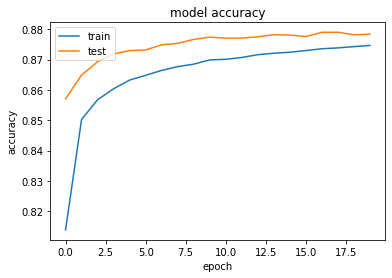

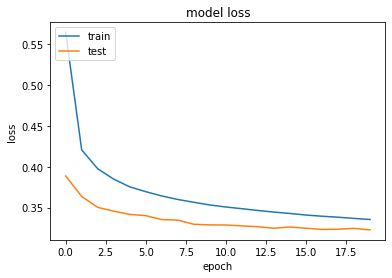

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

I test the trained model on one batch (128 samples) of test data and print the incorrectly predicted results to see what kind of mistakes my model does.

**First I print 25 correctly predicted** letters and digits and then I print **up to 25 incorrectly predicted** sampels.

In [11]:
test_sample = ds_test.take(1)
results = model.predict(test_sample)

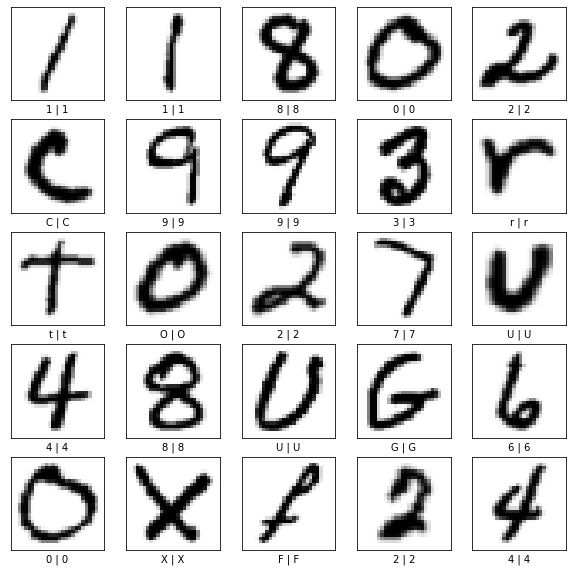

In [12]:
plt.figure(figsize=(10,10))

for sample in test_sample.take(1):
  batch_images = sample[0]
  batch_labels = sample[1]

  i = 0
  j = 0 
  while True:
    if i == 25:
      break
    else:
      j = j + 1       

      l_correct = tf.slice(batch_labels,[j],[1]).numpy()[0]
      l_predict = np.argmax(results[j])

      if l_correct == l_predict:
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        im = tf.slice(batch_images,[j,0,0,0],[1,28,28,1])
        im = tf.reshape(im,[28,28])
        im = tf.transpose(im)

        plt.imshow(im, cmap=plt.cm.binary)
        plt.xlabel(label_translate(l_correct) + " | " + label_translate(l_predict))
        
        i = i + 1
  plt.show()

InvalidArgumentError: ignored

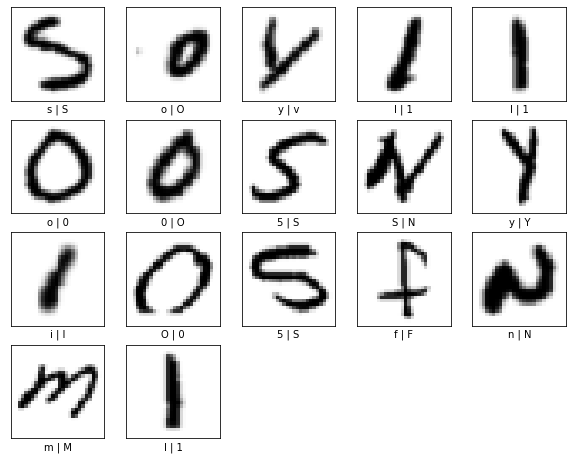

In [13]:
plt.figure(figsize=(10,10))

for sample in test_sample.take(1):
  batch_images = sample[0]
  batch_labels = sample[1]

  i = 0
  j = 0 
  while True:
    if i == 128:
      break
    else:
      j = j + 1       

      l_correct = tf.slice(batch_labels,[j],[1]).numpy()[0]
      l_predict = np.argmax(results[j])

      if l_correct != l_predict:
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        im = tf.slice(batch_images,[j,0,0,0],[1,28,28,1])
        im = tf.reshape(im,[28,28])
        im = tf.transpose(im)

        plt.imshow(im, cmap=plt.cm.binary)
        plt.xlabel(label_translate(l_correct) + " | " + label_translate(l_predict))
        
        i = i + 1
  plt.show()

In [14]:
model.save("model_EMNIST.hdf5")
from google.colab import files
files.download("model_EMNIST.hdf5")